# "Local feature descriptor"
> "How to learn good local feature descriptor and create a dense descriptor from it"
- toc: false
- image: images/doll_wbs_300.png
- branch: master
- badges: true
- comments: true
- hide: false
- search_exclude: false

![image.png](2020-03-30-descriptor_files/att_00002.png)

**Local feature** or **local patch descriptor** is a transformation of 2D image patch around the keypoint to a vector of floats or bits: $F_{\Theta}(\cdot): R^{PS \times PS} \rightarrow R^{D}$, where $\text{PS}$ is patch size in pixels and $D$ is dimentionality of the descriptor. Result of such transformation is often also called a **local descriptor**. 

The purpose of such transformation is that patch content could be efficiently compared to other descriptor allowing to establish tentative correspondences between keypoints. 
The benefits of $L_{2}$ or Hamming distances is that they allow fast approximate nearest neighbor search via libraries like FLANN \cite{FLANN2009}, faiss \cite{FAISS2017}, annoy \cite{annoy2018} and others. 


Ideal descriptor should map patch around keypoint so that, all patches belong to the keypoint in a real world (so 3D point) would have same or similar descriptions and different 3D points - different. **Of course, it is not possible**. Real world contains occlusions, self-occlusions, repeated patterns and is also changing with the time. So common requirements to the descriptors include robustness to _some_ degree of various nuisance factors: viewpoint change, illumination, and so on. There is also a trade-off between speed and robustness, precision and robustness and so on.

todo: Add image "patch" -> vector of numbers


---
## Note

I will skip for now intro and overview of existing descriptors for the next time. Now I am going to summarize my co-authors experience (Anastasiia Mishchuk, Milan Pultar, Filip Radenovic and Jiri Matas) about learning local feature descriptor -- HardNet.  

---

# Problem formulation: metric learning

We will parametrize the transformation $F_{\Theta}(\cdot)$, as deep convolution neural network (CNN)  $\Theta$, which parameters will be found by stochastic gradient descent (SGD) optimizing metric learning loss $L$ on some training dataset.
This leaves us several question to answer.

1. What is the architecture of CNN model?
2. Which loss function to use?
3. Which data to train on?
4. Is there anything specific to local descriptor learning, which is not common for other metric learning problems?

We will answer this questions in the following sections. First, we will describe the final model we proposed and the then provide the experiments, the recommendations are grounded on.

## Loss function


The metric learning offers a rich variety of the loss functions \cite{musgrave2020metric}. 
We would like to emulate the local descriptor matching process as close as possible in the training time. 

The matching descriptors should:
1. be each other nearest neighbors by descriptor distance 
2. pass reliability check, the most common of which is SNN ratio, \cite{Lowe99} so that descriptor distance to the correct match should be smaller that to the second nearest by some margin.


We select a triplet margin loss function~\cite{first margin loss function?}, where the negative example is the closest non-matching descriptor in the batch. The batch is formed by random sampling of pairs of matching patches.

\begin{equation}
L = \frac{1}{n}\sum_{i = 1,n}{\max{(0, 1 + d_p - d_n)}}
\end{equation}


![image.png](2020-03-30-descriptor_files/att_00003.p ng )

Moreover, to fully simulate wide baseline stereo setup, it is a good idea to sample pairs of patches from the same image, or at least from as little number of images as possible. The later is the case if batch size is larger than the number of detected keypoints in a single image pair. 
This single change  in sampling results in improving the results on [Image Matching Challenge 2020](https://vision.uvic.ca/image-matching-challenge/leaderboard/) from 0.654 to 0.660 mAA@$10^{\circ}$. 


## Model architecture


![](2020-03-30-descriptor_files/att_00000.png "L2Net/HardNet architecture. Numbers above channel maps denote spatial size, below -- number of channels. /2 means stride 2")

The architecture used in HardNet is first proposed in L2Net \cite{L2Net2017} and shown in Figure above. 

<!--  (Padding with zeros is applied to all convolutional layers, to preserve the spatial size, except to the final one. The spatial size is reduced by strided convolutions. Batch normalization \cite{BatchNorm2015} layer followed by ReLU \cite{RELU2010} non-linearity is added after each layer, except the last one. Dropout \cite{Dropout2014} regularization with 0.1 dropout rate is applied before the last convolution layer. The output of the network is L2 normalized to produce 128-D descriptor with unit-length. ) -->
 
Grayscale input patches with size $32 \times 32$ pixels are normalized by subtracting the per-patch mean and dividing by the per-patch standard deviation. 
 
Previous architectures very too small and shallow (TFeat \cite{TFeat2016}, DeepDesc\cite{simo2015deepdesc}) or directly borrowed from ImageNet architectures without any adaptation (MatchNet\cite{MatchNet2015}, DeepCompare\cite{DeepComp2015}). 

L2Net architecture took over them and has proven to work well: it is the de-facto standard CNN architecture for patch descriptors up to date: HardNet, GeoDesc\cite{geodesc2018}, SoSNet\cite{SoSNet2019}, R2D2\cite{revaud2019r2d2} use it as backbone. 


We have experimented with its modification, but were able to improve it only a little, resulting in HardNet8 architecture, which is definted below.

### Postprocessing

Similar to image retrieval setup\cite{GeM2018}, we found that first training descriptor with higher dimentionality and then whiten it, e.g. with PCA, to 128-dim improves results for the practical applications.




<!-- 
 (2020-03-30-descriptor_files/att_00001.png "TFeat architecture. Numbers above channel maps denote spatial size, below -- number of channels. /2 means stride 2"
-->

## Training data

That is the trickiest part, where we don't have a definite answer. But we present a recommendation of datasets to be used for two common setups.

## Training details

Optimization is done by **stochastic gradient descent** with **learning rate of 10 per batch size 1024**, **momentum of 0.9** and **weight decay of 0.0001**. **Learning rate was linearly decayed** \cite{Systematic2017} to zero within 10 "epochs" for the most of the experiments in this paper. 

"Epoch" here means 5M of patch pairs, sampled randomly. 

By "learning rate X per batch size BS" we mean with changing the batch size, one should proportionally change learning rate. 

Another setup, which works as good, or better, is to use **AdamW optimizer** \cite{AdamW2017} with **learning rate equal 3 per batch size 1024** and **1-cycle learning rate schedule** \cite{OneCycle2018}.


**Weights were initialized to orthogonal matrices** \cite{OrthoNorm2013} with gain equal to 0.6, biases set to 0.01 Training is done with PyTorch library \cite{pytorch2017}. 

## Things, specific to local patches

Typical patch size vary from 32x32 pixels to 64x64 pixels with 41x41 being standard for the handcrafted descriptors like SIFT. This allows to easily fit a large number of the samples into GPU memory, up to 16k depending on architecture, in constrast to typical batch size of 32-256 for the 256x256 images. Such big batches allow  big batches allow effective in-batch hard-negative mining.

The dataset are large scale, starting from 0.5M samples and have large number of classes (starting from 100k). 
Also, because of small image size, one could easily train for big number of epochs, e.g. training HardNet descriptor on Liberty for 220 epochs takes a couple of hours. 


The variance between different patches belonging to the same 3d point depends mostly on 3d viewpoint and illumination.

# Experiments

## Loss functions

## Batch size

## Sampling

## Data

# Omitted part: Augmentation

90 deg and mirroring for both. Others are not popular

# Important details: input normalization 

photometric normalization is SUPER importnant

## Initiazlization

**In progress**

## Patch descriptor -> fully convolutional. Does it worth it?

By simple conversion of HardNet to fullyconvolution pipeline, we can have descriptor, which is BETTER, then sota UCN deep descriptors

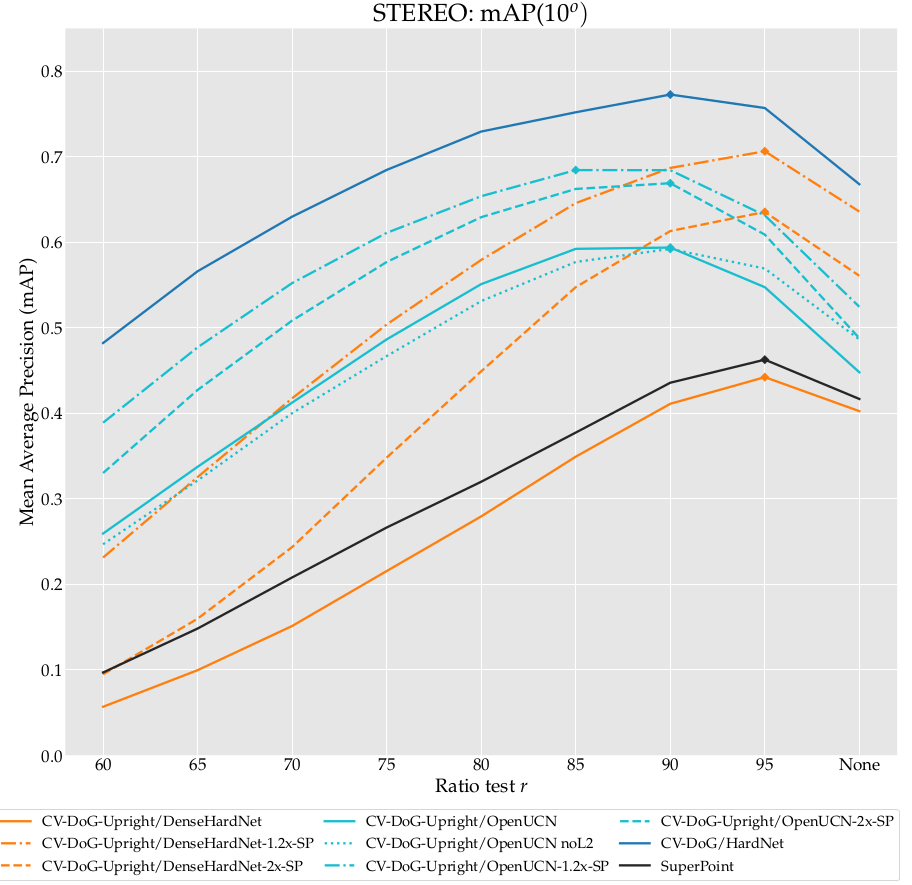

==============================
Method                                          | 640x480   |
1024x768 |  original images  |
DoG-HardNet sparse (standard)   |  0.192       |       0.340    |   0.747
DoG-HardNet DenseInterp            |  0.102       |       0.228    |   0.767
DoG-Dense-SpatialTrans              |  0.108       |       0.250    |   0.688
DoG-DenseUCN                            | 0.135       |       0.323
 | OOM GPU Error
OpenCV-SIFT (weak CPU)           |  0.075      |       0.222     |  0.787

So, patch-extraction HardNet is 2x slower for small images,  40%
slower on 1024x768  images and only 10% slower on original (mix of
sizes, from small to 3000x2000).



"threshold-based number of features" per image
seconds per image

==============================
Method                                          | 640x480   |
1024x768 |  original images  |
DoG-HardNet sparse (standard)   |  0.107       |      0.271     |   0.715
DoG-HardNet DenseInterp            |  0.089       |      0.210    |   0.659
DoG-Dense-SpatialTrans              |  0.108       |       0.185    |   0.593
DoG-DenseUCN                            | 0.126       |       0.348
 | OOM GPU Error
OpenCV-SIFT (weak CPU)           |  0.064       |        0.212     |   0.667

So if we detect less than 8k features, then
DoG->extract_patches->HardNet is quite good.
************


Now, the most interesting part. If I extract patches on GPU directly
instead of extracting on CPU and then transfer,
then classical method is actually faster, than fully-convolutional stuff.

8000 features per image
==============================
DoG-HardNet sparse (direct GPU)  |     0.124   |    0.218 |     0.621 |


"threshold-based features per image"
==============================
DoG-HardNet sparse (direct GPU)  |     0.077   |    0.213 |     0.574 |

# Task-dependent descriptor? Precision or recall?

# Augmentation

## Misc and thoughts



The receptive 

single batch  of the 

Note: setup is very different from CUB-200, Standord products. Specifically: large dataset (400k), small size (64x64), large number of classes (CUB, etc are small), big batches allow in-batch hard-negative mining. Classes are both different and same

Also because of small size (32x32), we can train for a long time: 10 x 5M pairs  == 220 epochs in Liberty. Probably, the closest thing - face recognition, although differences in faces are more subtle


Fancy stuff - doesn't work. Note: setup is very different from CUB-200, Standord products. Specifically: large dataset (400k), small size (64x64), large number of classes (CUB, etc are small), big batches allow in-batch hard-negative mining. Classes are both different and same

Also because of small size (32x32), we can train for a long time: 10 x 5M pairs  == 220 epochs in Liberty. Probably, the closest thing - face recognition, although differences in faces are more subtle



# References

(<a id="cit-FLANN2009" href="#call-FLANN2009">Muja and Lowe, 2009</a>) M. Muja and D.G. Lowe, ``_Fast Approximate Nearest Neighbors with Automatic Algorithm Configuration._'', VISAPP,  2009.

(<a id="cit-FAISS2017" href="#call-FAISS2017">Johnson, Douze <em>et al.</em>, 2017</a>) Johnson Jeff, Douze Matthijs and J{\'e}gou Herv{\'e}, ``_Billion-scale similarity search with GPUs_'', arXiv preprint arXiv:1702.08734, vol. , number , pp. ,  2017.

(<a id="cit-annoy2018" href="#call-annoy2018">Bernhardsson, 2018</a>) Erik Bernhardsson, ``_Annoy: Approximate Nearest Neighbors in C++/Python_'',  2018.  [online](https://pypi.org/project/annoy/)

(<a id="cit-musgrave2020metric" href="#call-musgrave2020metric">Musgrave, Belongie <em>et al.</em>, 2020</a>) Musgrave Kevin, Belongie Serge and Lim Ser-Nam, ``_A Metric Learning Reality Check_'', arXiv e-prints, vol. , number , pp. ,  2020.

(<a id="cit-Lowe99" href="#call-Lowe99">Lowe, 1999</a>) D. Lowe, ``_Object Recognition from Local Scale-Invariant Features_'', ICCV,  1999.

(<a id="cit-L2Net2017" href="#call-L2Net2017">Yurun Tian, 2017</a>) F.W. Yurun Tian, ``_L2-Net: Deep Learning of Discriminative Patch Descriptor in Euclidean Space_'', CVPR,  2017.

(<a id="cit-BatchNorm2015" href="#call-BatchNorm2015">Ioffe and Szegedy, 2015</a>) Ioffe Sergey and Szegedy Christian, ``_Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift_'', ArXiv 1502.03167, vol. , number , pp. ,  2015.

(<a id="cit-RELU2010" href="#call-RELU2010">Nair and Hinton, 2010</a>) V. Nair and G.E. Hinton, ``_Rectified linear units improve restricted boltzmann machines_'', International Conference on Machine Learning (ICML),  2010.

(<a id="cit-Dropout2014" href="#call-Dropout2014">Srivastava, Hinton <em>et al.</em>, 2014</a>) Srivastava Nitish, Hinton Geoffrey E, Krizhevsky Alex <em>et al.</em>, ``_Dropout: a simple way to prevent neural networks from overfitting._'', Journal of Machine Learning Research (JMLR), vol. 15, number 1, pp. 1929--1958,  2014.

(<a id="cit-TFeat2016" href="#call-TFeat2016">Balntas, Riba <em>et al.</em>, 2016</a>) V. Balntas, E. Riba, D. Ponsa <em>et al.</em>, ``_Learning local feature descriptors with triplets and shallow convolutional neural networks_'', British Machine Vision Conference (BMVC),  2016.

(<a id="cit-simo2015deepdesc" href="#call-simo2015deepdesc">Simo-Serra, Trulls <em>et al.</em>, 2015</a>) E. Simo-Serra, E. Trulls, L. Ferraz <em>et al.</em>, ``_Discriminative Learning of Deep Convolutional Feature Point Descriptors_'', ICCV,  2015.

(<a id="cit-MatchNet2015" href="#call-MatchNet2015">Han, Leung <em>et al.</em>, 2015</a>) X. Han, T. Leung, Y. Jia <em>et al.</em>, ``_MatchNet: Unifying feature and metric learning for patch-based matching_'', CVPR,  2015.

(<a id="cit-DeepComp2015" href="#call-DeepComp2015">Zagoruyko and Komodakis, 2015</a>) S. Zagoruyko and N. Komodakis, ``_Learning to Compare Image Patches via Convolutional Neural Networks_'', CVPR,  2015.

(<a id="cit-geodesc2018" href="#call-geodesc2018">Luo, Shen <em>et al.</em>, 2018</a>) Z. Luo, T. Shen, L. Zhou <em>et al.</em>, ``_GeoDesc: Learning Local Descriptors by Integrating Geometry Constraints_'', ECCV,  2018.

(<a id="cit-SoSNet2019" href="#call-SoSNet2019">Tian, Yu <em>et al.</em>, 2019</a>) Y. Tian, X. Yu, B. Fan <em>et al.</em>, ``_SOSNet: Second order similarity regularization for local descriptor learning_'', CVPR,  2019.

(<a id="cit-revaud2019r2d2" href="#call-revaud2019r2d2">Revaud, Weinzaepfel <em>et al.</em>, 2019</a>) J. Revaud, P. Weinzaepfel, C. De Souza <em>et al.</em>, ``_R2d2: Repeatable and reliable detector and descriptor_'', NeurIPS,  2019.

(<a id="cit-Systematic2017" href="#call-Systematic2017">Mishkin, Sergievskiy <em>et al.</em>, 2017</a>) Mishkin Dmytro, Sergievskiy Nikolay and Matas Jiri, ``_Systematic evaluation of convolution neural network advances on the Imagenet_'', Computer Vision and Image Understanding, vol. 161, number , pp. 11 - 19,  2017.

(<a id="cit-AdamW2017" href="#call-AdamW2017">Loshchilov and Hutter, 2017</a>) Loshchilov Ilya and Hutter Frank, ``_Decoupled weight decay regularization_'', arXiv preprint arXiv:1711.05101, vol. , number , pp. ,  2017.

(<a id="cit-OneCycle2018" href="#call-OneCycle2018">Smith, 2018</a>) Smith Leslie N, ``_A disciplined approach to neural network hyper-parameters: Part 1--learning rate, batch size, momentum, and weight decay_'', arXiv preprint arXiv:1803.09820, vol. , number , pp. ,  2018.

(<a id="cit-OrthoNorm2013" href="#call-OrthoNorm2013">M., L. <em>et al.</em>, 2014</a>) A. M., J. L. and S. Ganguli, ``_Exact solutions to the nonlinear dynamics of learning in deep linear neural networks_'', Proceedings of ICLR,  2014.

(<a id="cit-pytorch2017" href="#call-pytorch2017">Paszke, Gross <em>et al.</em>, 2017</a>) A. Paszke, S. Gross, S. Chintala <em>et al.</em>, ``_Automatic differentiation in PyTorch_'', NeurIPS-W,  2017.

